In [58]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import pandas as pd
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'figures'))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [59]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":16,
                                "axes.labelsize":13})

In [4]:
def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks

## Data

In [60]:
DYNAMO_BASE_PATH = os.path.join(BASE_PATH, 'LambdaML', 'examples', 'lambda', 'dynamo', 'out')
SMI_BASE_BATH = os.path.join(BASE_PATH, 'LambdaML', 'examples', 'lambda', 'smibench', 'out')
NUM_NODES = [2, 4, 8, 16, 32, 64, 128, 256]

In [61]:
exp_data = {"n": [], "latency": [], "method": []}
for num_node in NUM_NODES:
    comm_times = []
    for i in range(num_node):
        if num_node <= 64:
            dynamo_path = os.path.join(DYNAMO_BASE_PATH, "{}_{}.json".format(num_node, i))
            with open(dynamo_path, "r") as json_file:
                data = json.load(json_file)
                for comm_time in data['comm_times'][1:]:
                    exp_data["n"].append(num_node)
                    exp_data["latency"].append(comm_time * 1000)
                    exp_data["method"].append("DynamoDB")
        smi_path = os.path.join(SMI_BASE_BATH, "{}_{}.json".format(num_node, i))
        with open(smi_path, "r") as json_file:
            data = json.load(json_file)
            for comm_time in data['comm_times'][1:]:
                exp_data["n"].append(num_node)
                exp_data["latency"].append(comm_time * 1000)
                exp_data["method"].append("FMI")
vals = pd.DataFrame(exp_data)
vals.groupby(['method', 'n']).mean()
#vals.groupby(['method', 'n']).max()

latency
method   n               
DynamoDB 2     211.855425
         4     122.318546
         8     116.864512
         16    142.260955
         32    616.407803
         64   6998.925144
FMI      2       0.819895
         4       1.445386
         8       4.171421
         16      3.508437
         32      6.418258
         64      6.772749
         128    16.919665
         256    20.495893

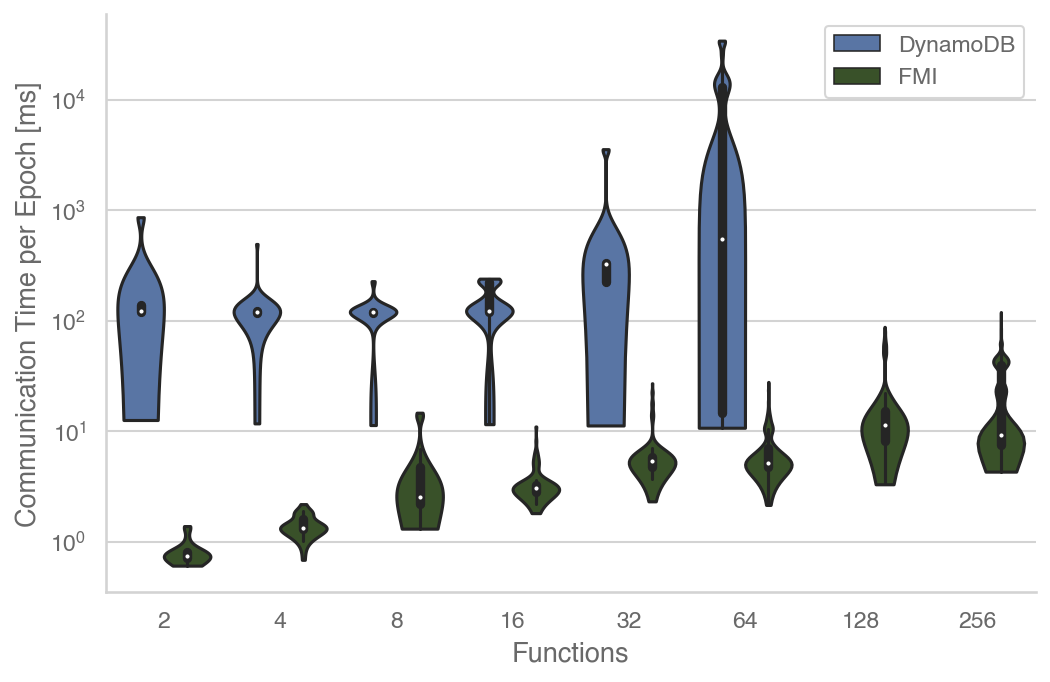

In [54]:
my_pal = {"DynamoDB": "b", "FMI": "#385723"}
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.set_yscale('log')
sns.violinplot(x="n", y="latency", hue="method", data=vals, ax=ax, cut=0, palette=my_pal, scale="count")
ax.set_xlabel("Functions")
ax.set_ylabel("Communication Time per Epoch [ms]")
ax.legend()
#fig.savefig(os.path.join(OUTPUT_PATH, "fmi_benchmark_lambdaml.pdf"), bbox_inches='tight')

2 0.008965061616195574 211.85542477501764 0.21185542477501765 121.59764766693115 0.0019031999999999999
smi 2 0.013424982343411445 0.81989500257704 0.0134
4 0.01196098604095777 122.31854597727458 0.12231854597727458 120.87535858154297 0.0038063999999999997
smi 4 0.013489891931390764 1.4453861448499892 0.0134
8 0.023194766145745914 116.86451236406963 0.11686451236406963 120.51928043365479 0.007612799999999999
smi 8 0.013736615917778016 4.17142113049825 0.0134
16 0.05316193065642251 142.26095543967352 0.14226095543967351 122.52426147460938 0.015225599999999999
smi 16 0.014213422240447998 3.508437010977003 0.0134
32 0.35920268552055096 616.4078025354279 0.6164078025354279 330.07562160491943 0.030451199999999998
smi 32 0.016262109504318237 6.41825795173645 0.0134
64 7.5264374851456015 6998.925144473712 6.998925144473712 546.5426445007324 0.060902399999999995
smi 64 0.018972266596984866 6.7727487120363445 0.0134
2 0.008965061616195574 0.013424982343411445 0.6677894530412802
4 0.0119609860409

'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


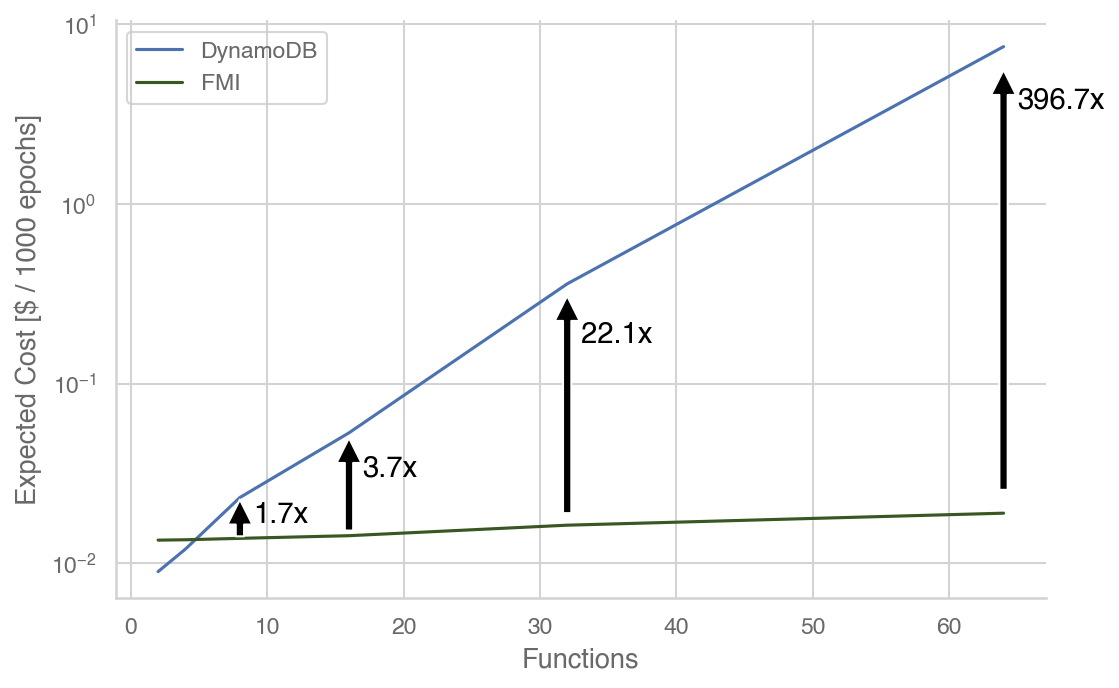

In [100]:
import scipy.stats as st
ec2_instance_price = 0.0134
gib_second_price = 0.0000166667
dynamodb_rcu_price = 0.0001586
dynamodb_wcu_price = 0.000793

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Functions")
ax.set_ylabel("Expected Cost [$ / 1000 epochs]")
#ax.set_xticks(list(one_to_many_scalability_means["S3"].keys()))
#ax.set_xticklabels(format_xticks(one_to_many_scalability_means["S3"].keys()))
ddb_lower_error, ddb_upper_error = [], []
ddb_plot_data = {}
smi_lower_error, smi_upper_error = [], []
smi_plot_data = {}
for num_node in NUM_NODES:
    if num_node > 64:
        continue

    dynamodb_data = vals[(vals['n'] == num_node) & (vals['method'] == "DynamoDB")]['latency']
    dynamodb_mean = np.mean(dynamodb_data)
    dynamodb_median = np.median(dynamodb_data)
    low, high = st.t.interval(0.95, len(dynamodb_data) - 1, loc=dynamodb_mean, scale=st.sem(dynamodb_data))
    ddb_fixed_cost = num_node * dynamodb_rcu_price + num_node * dynamodb_wcu_price
    mean_s = dynamodb_mean /1000
    ddb_price = dynamodb_mean * num_node * 1000 / 1000 * gib_second_price + ddb_fixed_cost
    #ddb_price *= 1000
    low_price = low * num_node * 1000 / 1000 * gib_second_price + ddb_fixed_cost
    high_price = high * num_node * 1000 / 1000 * gib_second_price + ddb_fixed_cost
    ddb_plot_data[num_node] = ddb_price
    ddb_lower_error.append(low_price)
    ddb_upper_error.append(high_price)
    print(num_node,ddb_price, dynamodb_mean, mean_s, dynamodb_median, ddb_fixed_cost)

    smi_data = vals[(vals['n'] == num_node) & (vals['method'] == "FMI")]['latency']
    smi_mean = np.mean(smi_data)
    smi_median = np.median(smi_data)
    low, high = st.t.interval(0.95, len(smi_data) - 1, loc=smi_mean, scale=st.sem(smi_data))
    smi_fixed_cost = ec2_instance_price
    #smi_price = smi_mean * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    smi_price = smi_median * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    low_price = low * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    high_price = high * num_node * 1000 / 1000 * gib_second_price + smi_fixed_cost
    smi_plot_data[num_node] = smi_price
    smi_lower_error.append(low_price)
    smi_upper_error.append(high_price)
    print('smi', num_node,smi_price,smi_mean, smi_fixed_cost)
    
#ax.errorbar(ddb_plot_data.keys(), ddb_plot_data.values(), [ddb_lower_error, ddb_upper_error], elinewidth=1, capsize=4, label="DynamoDB", color="b")
#ax.errorbar(smi_plot_data.keys(), smi_plot_data.values(), [smi_lower_error, smi_upper_error], elinewidth=1, capsize=4, label="FMI", color="#385723")
ax.errorbar(ddb_plot_data.keys(), ddb_plot_data.values(), elinewidth=1, capsize=4, label="DynamoDB", color="b")
ax.errorbar(smi_plot_data.keys(), smi_plot_data.values(), elinewidth=1, capsize=4, label="FMI", color="#385723")

for key, d, s in zip(ddb_plot_data.keys(), ddb_plot_data.values(), smi_plot_data.values()):
    print(key, d, s, d/s)
    if key < 8:
        continue
    ax.annotate(text='', xy=(key, d), xytext=(key, s), arrowprops=dict(facecolor='black',shrink=0.05))#, shrink=0.02))
    ax.annotate(f'{round(d/s, 1)}x', xy=(key, d), xytext=(key+1, s+(d-s)/2), color='black', va='center')
    #ax.annotate(f'{round(d/s, 1)}x', xy=(2, 1), xytext=(3, 1.5), arrowprops=dict(facecolor='black', shrink=0.05))

print(ddb_plot_data)
print(smi_plot_data)
ax.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "fmi_benchmark_lambdaml_costs.pdf"), bbox_inches='tight')
plt.show()